# Clean-Label Feature Collision Attacks on a Keras Classifier

In [1]:
# import torch
# a = torch.empty(5, 7, dtype=torch.float)
# print(id(a))
# print(a)

In [2]:
# import numpy as np
# b = torch.tensor(np.random.rand(5,7))
# print(b)
# print(id(b))
# a.data.copy_(b.data)
# print(id(a))
# print(a)

In [3]:
pwd

'/home/shritipriya/adversarial-robustness-toolbox/notebooks'

In this notebook, we will learn how to use ART to run a clean-label feature collision poisoning attack on a neural network trained with Keras. We will be training our data on a subset of the CIFAR-10 dataset. The methods described are derived from [this paper](https://arxiv.org/abs/1804.00792) by Shafahi, Huang, et. al. 2018.

In [4]:
import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')


import torch
import torch.nn as nn

from art import config
from art.utils import load_dataset, get_file
from art.estimators.classification import PyTorchClassifier
from art.attacks.poisoning import FeatureCollisionAttack

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

np.random.seed(301)

In [5]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('cifar10')
num_samples_train = 1000
num_samples_test = 1000
x_train = x_train[0:num_samples_train]
y_train = y_train[0:num_samples_train]
x_test = x_test[0:num_samples_test]
y_test = y_test[0:num_samples_test]

class_descr = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Transpose the axes to make input of acceptable format by PyTorchClassifier
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

print("shape of x_train",x_train.shape)
print("shape of y_train",y_train.shape)

shape of x_train (1000, 32, 32, 3)
shape of y_train (1000, 10)


## Load Model to be Attacked

In this example, we using a RESNET50 model pretrained on the CIFAR dataset.

In [6]:
import torch.optim as optim
classifier_model = torch.load('ciafr10_alexnet_pytorch_linear.pt')
# for param in classifier_model.parameters():
#     param.requires_grad = False
classifier_model.eval()
criterion =  nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier_model.parameters(), lr=0.0001)
classifier = PyTorchClassifier(clip_values=(min_, max_), model=classifier_model, 
                             preprocessing=(0.5,1),nb_classes=10,input_shape=(32,32,3),loss=criterion,
                             optimizer=optimizer)


In [7]:
classifier_model

Model(
  (_Model__vars): ParameterDict(
      (t_classifier_3_kernel_0): Parameter containing: [torch.cuda.FloatTensor of size 64x10 (GPU 0)]
      (t_classifier_3_bias_0): Parameter containing: [torch.cuda.FloatTensor of size 10 (GPU 0)]
      (t_scale): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
      (t_bias): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
      (t_mean): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
      (t_var): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
      (t_conv2d_33_3_kernel_0): Parameter containing: [torch.cuda.FloatTensor of size 64x64x3x3 (GPU 0)]
      (t_conv2d_33_3_bias_0): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
      (t_conv2d_31_3_kernel_0): Parameter containing: [torch.cuda.FloatTensor of size 64x64x3x3 (GPU 0)]
      (t_conv2d_31_3_bias_0): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
      (t_conv2d_29_3_kernel_0):

## Choose Target Image from Test Set

shape of target_instance (32, 32, 3)
shape of img_plot (32, 32, 3)
shape of target_instance (1, 32, 32, 3)
true_class: bird
predicted_class: bird
n_n_linear_1


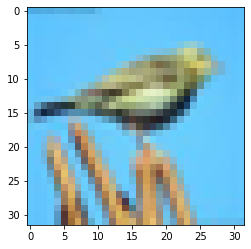

In [8]:
target_class = "bird" # one of ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
target_label = np.zeros(len(class_descr))
target_label[class_descr.index(target_class)] = 1
target_instance = np.expand_dims(x_test[np.argmax(y_test, axis=1) == class_descr.index(target_class)][3], axis=0)
print("shape of target_instance",target_instance[0].shape)
img_plot = target_instance[0]
print("shape of img_plot",img_plot.shape)
fig = plt.imshow(img_plot)
print("shape of target_instance",target_instance.shape)
print('true_class: ' + target_class)
print('predicted_class: ' + class_descr[np.argmax(classifier.predict(target_instance), axis=1)[0]])

feature_layer = classifier.layer_names[-1]
print(feature_layer)

In [9]:
classifier.layer_names

['_Model__vars',
 'n_n_conv2d_1',
 'n_n_conv2d_2',
 'n_n_conv2d_3',
 'n_n_batch_normalization_3',
 'n_n_conv2d_4',
 'n_n_conv2d_5',
 'n_n_batch_normalization_5',
 'n_n_conv2d_6',
 'n_n_conv2d_7',
 'n_n_batch_normalization_7',
 'n_n_conv2d_8',
 'n_n_conv2d_9',
 'n_n_batch_normalization_9',
 'n_n_conv2d_10',
 'n_n_conv2d_11',
 'n_n_conv2d_14',
 'n_n_batch_normalization_11',
 'n_n_conv2d_12',
 'n_n_conv2d_13',
 'n_n_batch_normalization_13',
 'n_n_conv2d_15',
 'n_n_conv2d_16',
 'n_n_batch_normalization_15',
 'n_n_conv2d_17',
 'n_n_conv2d_18',
 'n_n_batch_normalization_17',
 'n_n_conv2d_19',
 'n_n_conv2d_20',
 'n_n_batch_normalization_19',
 'n_n_conv2d_21',
 'n_n_conv2d_22',
 'n_n_conv2d_25',
 'n_n_batch_normalization_21',
 'n_n_conv2d_23',
 'n_n_conv2d_24',
 'n_n_batch_normalization_23',
 'n_n_conv2d_26',
 'n_n_conv2d_27',
 'n_n_batch_normalization_25',
 'n_n_conv2d_28',
 'n_n_conv2d_29',
 'n_n_batch_normalization_27',
 'n_n_conv2d_30',
 'n_n_conv2d_31',
 'n_n_batch_normalization_29',
 'n_

In [10]:
# import torchviz

# target_instance = torch.from_numpy(target_instance).cuda()
# y = classifier_model(target_instance)
# print(y)
# torchviz.dot.make_dot(y.mean(), params=dict(classifier_model.named_parameters()))

In [11]:
# pip install graphviz


# Calculate Accuracy of Model

In [12]:
x_test_pred = np.argmax(classifier.predict(x_test), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test, axis=1))
print("Benign accuracy of the model: {}".format(100*(nb_correct_pred/1000)))

Benign accuracy of the model: 90.60000000000001


## Poison Training Images to Misclassify Test

The attacker wants to make it such that whenever a prediction is made on this particular cat the output will be a horse.

In [13]:
base_class = "frog" # one of ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
base_idxs = np.argmax(y_test, axis=1) == class_descr.index(base_class)
base_instances = np.copy(x_test[base_idxs][:10])
base_labels = y_test[base_idxs][:10]
print("shape of base_instances",base_instances.shape)
print("shape of base_labels",base_labels.shape)
x_test_pred = np.argmax(classifier.predict(base_instances), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(base_labels, axis=1))

print("New test data to be poisoned (10 images):")
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(10-nb_correct_pred))

shape of base_instances (10, 32, 32, 3)
shape of base_labels (10, 10)
New test data to be poisoned (10 images):
Correctly classified: 9
Incorrectly classified: 1


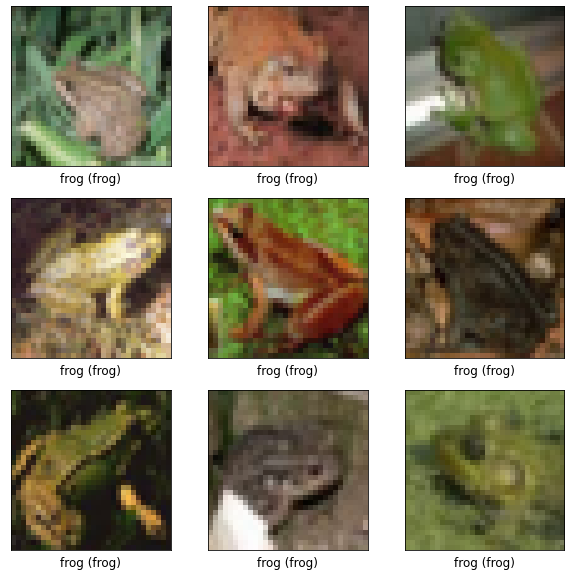

In [14]:
plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label, true_label = class_descr[x_test_pred[i]], class_descr[np.argmax(base_labels[i])]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(base_instances[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')

The captions on the images can be read: `predicted label (true label)`

# Computation Graph Visualization

## Creating Poison Frogs

In [15]:
np.expand_dims(base_instances[0],axis=0).shape

(1, 32, 32, 3)

In [16]:
# Keep this fixed
# max_iter = 10
attack = FeatureCollisionAttack(classifier, 
                                target_instance, 
                                feature_layer, 
                                max_iter=10, 
                                similarity_coeff=256,
                                watermark=0.3)
#poison, poison_labels = attack.poison(np.expand_dims(base_instances[0],axis=0))
poison, poison_labels = attack.poison(base_instances)

target max 1.0
target min 0.050980393
target_features max 6.4562984
target_features min -8.706204
poison_features max 20.318945
poison_features min -10.06916
2nd time poison_features max 20.318945
2nd time poison_features min -10.06916
Learning rate: 0.01


Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

self.attack_loss MSELoss()
True
False
True
False
tensor(37.9862, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -41.849236 31.938046
self.attack_loss MSELoss()
True
False
True
False
tensor(17.6592, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -9.434174 9.055972
self.attack_loss MSELoss()
True
False
True
False
tensor(5.1223, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -4.5749164 4.0351076
self.attack_loss MSELoss()
True
False
True
False
tensor(4.6637, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -4.8334846 4.6602716
self.attack_loss MSELoss()
True
False
True
False
tensor(4.1607, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -5.06713 6.266883
self.attack_loss MSELoss()
True
False
True
False
tensor(7.1079, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -7.43748 6.367909
self.attack_loss MSELoss()
True
False
True
False
tensor(6.2164, device='cuda:0', g

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

self.attack_loss MSELoss()
True
False
True
False
tensor(89.9416, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -92.31663 76.30504
self.attack_loss MSELoss()
True
False
True
False
tensor(35.3994, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -22.5934 26.721926
self.attack_loss MSELoss()
True
False
True
False
tensor(7.7377, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -7.986894 10.735788
self.attack_loss MSELoss()
True
False
True
False
tensor(34.1608, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -12.332612 9.374131
self.attack_loss MSELoss()
True
False
True
False
tensor(16.4185, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -7.088024 9.076568
self.attack_loss MSELoss()
True
False
True
False
tensor(5.8562, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -5.0006976 5.2094526
self.attack_loss MSELoss()
True
False
True
False
tensor(1.7525, device='cuda:0',

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

self.attack_loss MSELoss()
True
False
True
False
tensor(44.2502, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -48.822517 47.413727
self.attack_loss MSELoss()
True
False
True
False
tensor(56.7971, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -27.076609 22.168491
self.attack_loss MSELoss()
True
False
True
False
tensor(20.5302, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -16.792055 17.682495
self.attack_loss MSELoss()
True
False
True
False
tensor(9.7379, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -8.023407 6.6239076
self.attack_loss MSELoss()
True
False
True
False
tensor(1.5591, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -2.4915679 2.0849564
self.attack_loss MSELoss()
True
False
True
False
tensor(0.4722, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -0.8956003 1.120677
self.attack_loss MSELoss()
True
False
True
False
tensor(0.2014, device='cud

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

self.attack_loss MSELoss()
True
False
True
False
tensor(79.4814, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -79.97412 46.75811
self.attack_loss MSELoss()
True
False
True
False
tensor(34.6916, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -29.55101 22.057554
self.attack_loss MSELoss()
True
False
True
False
tensor(19.4847, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -12.6820545 16.294403
self.attack_loss MSELoss()
True
False
True
False
tensor(4.5057, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -5.3067117 6.0731936
self.attack_loss MSELoss()
True
False
True
False
tensor(1.1458, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -1.8940071 2.2462718
self.attack_loss MSELoss()
True
False
True
False
tensor(0.0940, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -0.6567503 0.61804646
self.attack_loss MSELoss()
True
False
True
False
tensor(0.0495, device='cu

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

self.attack_loss MSELoss()
True
False
True
False
tensor(87.0676, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -53.91002 39.10796
self.attack_loss MSELoss()
True
False
True
False
tensor(24.6125, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -13.915186 14.238284
self.attack_loss MSELoss()
True
False
True
False
tensor(5.6590, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -5.2940683 7.0793686
self.attack_loss MSELoss()
True
False
True
False
tensor(3.4216, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -6.344503 5.925517
self.attack_loss MSELoss()
True
False
True
False
tensor(3.6919, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -6.471707 7.6583233
self.attack_loss MSELoss()
True
False
True
False
tensor(2.3350, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -4.416809 3.7558155
self.attack_loss MSELoss()
True
False
True
False
tensor(0.8043, device='cuda:0',

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

self.attack_loss MSELoss()
True
False
True
False
tensor(73.0110, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -64.06147 91.38227
self.attack_loss MSELoss()
True
False
True
False
tensor(33.5078, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -20.468815 19.995441
self.attack_loss MSELoss()
True
False
True
False
tensor(14.3142, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -10.25992 12.080305
self.attack_loss MSELoss()
True
False
True
False
tensor(5.9880, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -8.106859 11.416264
self.attack_loss MSELoss()
True
False
True
False
tensor(2.5961, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -4.511468 5.337965
self.attack_loss MSELoss()
True
False
True
False
tensor(2.3217, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -8.522235 6.910136
self.attack_loss MSELoss()
True
False
True
False
tensor(3.0124, device='cuda:0', 

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

self.attack_loss MSELoss()
True
False
True
False
tensor(41.7717, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -68.34608 41.4924
self.attack_loss MSELoss()
True
False
True
False
tensor(20.8774, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -24.708817 22.250484
self.attack_loss MSELoss()
True
False
True
False
tensor(8.1752, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -10.488897 7.8216624
self.attack_loss MSELoss()
True
False
True
False
tensor(8.2414, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -11.5672035 10.170201
self.attack_loss MSELoss()
True
False
True
False
tensor(6.5500, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -8.066864 6.039688
self.attack_loss MSELoss()
True
False
True
False
tensor(1.7068, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -4.0671396 4.9367924
self.attack_loss MSELoss()
True
False
True
False
tensor(3.4913, device='cuda:0

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

self.attack_loss MSELoss()
True
False
True
False
tensor(58.5765, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -38.84655 63.5695
self.attack_loss MSELoss()
True
False
True
False
tensor(39.9087, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -19.725704 18.487713
self.attack_loss MSELoss()
True
False
True
False
tensor(15.3068, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -14.108611 10.829599
self.attack_loss MSELoss()
True
False
True
False
tensor(4.7650, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -8.006472 11.676396
self.attack_loss MSELoss()
True
False
True
False
tensor(9.8103, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -10.992636 11.870387
self.attack_loss MSELoss()
True
False
True
False
tensor(9.0314, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -9.690191 8.7050905
self.attack_loss MSELoss()
True
False
True
False
tensor(8.1254, device='cuda:0

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

self.attack_loss MSELoss()
True
False
True
False
tensor(33.5461, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -35.110435 22.438519
self.attack_loss MSELoss()
True
False
True
False
tensor(14.4779, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -17.337408 14.220528
self.attack_loss MSELoss()
True
False
True
False
tensor(3.2365, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -10.098849 7.2615256
self.attack_loss MSELoss()
True
False
True
False
tensor(9.3644, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -10.080753 10.548633
self.attack_loss MSELoss()
True
False
True
False
tensor(5.9791, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -12.772366 9.984912
self.attack_loss MSELoss()
True
False
True
False
tensor(4.3983, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -5.7518363 7.2873707
self.attack_loss MSELoss()
True
False
True
False
tensor(0.7565, device='cud

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

self.attack_loss MSELoss()
True
False
True
False
tensor(91.7781, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -138.2435 173.43701
self.attack_loss MSELoss()
True
False
True
False
tensor(38.7958, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -15.276666 15.888662
self.attack_loss MSELoss()
True
False
True
False
tensor(4.8185, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -4.280837 6.6657443
self.attack_loss MSELoss()
True
False
True
False
tensor(4.4012, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -6.5328636 6.0862145
self.attack_loss MSELoss()
True
False
True
False
tensor(7.5612, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -7.7908444 11.621297
self.attack_loss MSELoss()
True
False
True
False
tensor(6.9738, device='cuda:0', grad_fn=<MseLossBackward0>)
Value of attack_grad[0] -9.976392 7.3983026
self.attack_loss MSELoss()
True
False
True
False
tensor(3.4431, device='cuda:

In [17]:
poison

array([[[[0.35269424, 0.41450295, 0.4516297 ],
         [0.3626949 , 0.44998533, 0.47896516],
         [0.28673503, 0.42810288, 0.40343043],
         ...,
         [0.34281906, 0.58377814, 0.50196004],
         [0.29670775, 0.50981915, 0.49483472],
         [0.3582105 , 0.5535548 , 0.55172503]],

        [[0.40907156, 0.55192333, 0.5478129 ],
         [0.40501383, 0.64269775, 0.6254103 ],
         [0.3568242 , 0.5971086 , 0.53203964],
         ...,
         [0.31934252, 0.498196  , 0.478221  ],
         [0.36762258, 0.55363655, 0.5619186 ],
         [0.36410725, 0.5476254 , 0.5647479 ]],

        [[0.36833975, 0.600197  , 0.5882231 ],
         [0.37365785, 0.69912124, 0.67886186],
         [0.35397032, 0.66485405, 0.61418736],
         ...,
         [0.4003592 , 0.5661068 , 0.56246513],
         [0.44374454, 0.5902486 , 0.5895568 ],
         [0.31190366, 0.44585106, 0.49657387]],

        ...,

        [[0.5156908 , 0.71675754, 0.6547315 ],
         [0.55996686, 0.69642717, 0.66054636]

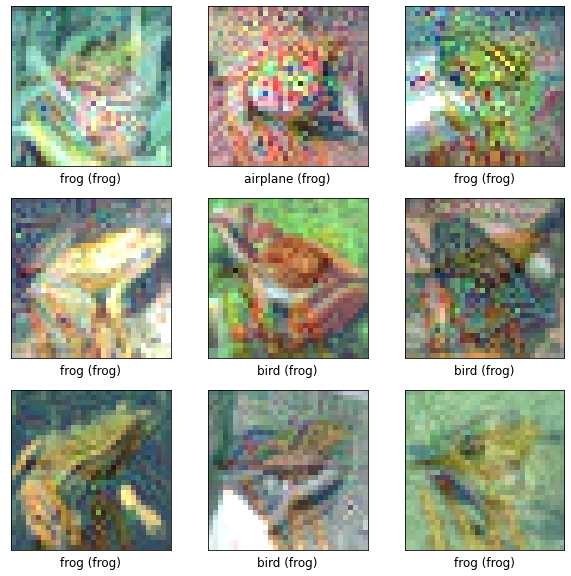

In [18]:
poison_pred = np.argmax(classifier.predict(poison), axis=1)
plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label, true_label = class_descr[poison_pred[i]], class_descr[np.argmax(poison_labels[i])]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(poison[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')


Notice how the network classifies most of theses poison examples as frogs, and it's not incorrect to do so. The examples look mostly froggy. A slight watermark of the target instance is also added to push the poisons closer to the target class in feature space.

## Training with Poison Images

In [ ]:
import torch.optim as optim
adv_train = np.vstack([x_train, poison])
adv_labels = np.vstack([y_train, poison_labels])
classifier_model.train()
classifier.fit(adv_train, adv_labels, nb_epochs=25, batch_size=4)

## Fooled Network Misclassifies Bird

In [ ]:
fig = plt.imshow(target_instance[0])

print('true_class: ' + target_class)
print('predicted_class: ' + class_descr[np.argmax(classifier.predict(target_instance), axis=1)[0]])

These attacks allow adversaries who can poison your dataset the ability to mislabel any particular target instance of their choosing without manipulating labels.

In [ ]:
x_test_pred = np.argmax(classifier.predict(x_test), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test, axis=1))
print("Benign accuracy of the model: {}".format(100*(nb_correct_pred/1000)))